<a href="https://colab.research.google.com/github/Armin-Abdollahi/WhiteTree-International-Academy/blob/main/Emotiv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from PIL import Image
import io
from datetime import datetime
# Read the CSV file, skipping the first row
file_path = '/content/Arses_Mohammadi_INSIGHT_266576_2025.01.31T11.34.11_03.30.pm.bp.csv'
df = pd.read_csv(file_path, skiprows=1)

# Extract the patient's name from the file name
file_name = os.path.basename(file_path)
if '_INSIGHT_' in file_name:
    patient_name = file_name.split('_INSIGHT_')[0]
elif '_EPOCPLUS_' in file_name:
    patient_name = file_name.split('_EPOCPLUS_')[0]
else:
    patient_name = 'Unknown'

In [ ]:
def plot_maker(df, output_pdf='report.pdf', report_type='General'):
  # Create a PDF object
  pdf = PdfPages(output_pdf)

  # Add logo and title
  fig_title = plt.figure(figsize=(8.27, 11.69))
  plt.axis('off')

  # Load and display logo
  logo = Image.open('/content/Screenshot.jpg')
  logo_ax = fig_title.add_subplot(411)
  logo_ax.imshow(logo)
  logo_ax.axis('off')

  # Add title
  title_ax = fig_title.add_subplot(412)
  title_ax.text(0.5, 0.6, "White Tree International Academy",
                fontsize=24, ha='center', va='center')
  title_ax.text(0.5, 0.4, "Performance Metric Analysis",
                fontsize=18, ha='center', va='center')
  title_ax.axis('off')

  # Add report types
  report_types_ax = fig_title.add_subplot(413)
  general_check = '☑' if report_type == 'General' else '☐'
  rest_check = '☑' if report_type == 'Rest' else '☐'
  attention_check = '☑' if report_type == 'Attention' else '☐'
  report_types_ax.text(0.5, 0.5, f"Report Type:\n\n {general_check} General Report    {rest_check} Rest Report    {attention_check} Attention Report",
                      fontsize=18, ha='center', va='center')
  report_types_ax.axis('off')


  # Add patient name and date and time
  name_ax = fig_title.add_subplot(414)
  date = datetime.now().strftime('%Y-%m-%d')
  time = datetime.now().strftime('%H:%M:%S')
  name_ax.text(0.5, 0.5, f"Name: {patient_name}\n\nDate: {date}\nTime: {time}",
              fontsize=18, ha='center', va='center')
  name_ax.axis('off')
  pdf.savefig(fig_title)

  # Get the column names from the second row
  column_names = df.columns.tolist()

  # -------------------------------------------------- Figure 1 --------------------------------------------------

  # Figure 1: Correlation Matrix Heatmap
  raw_cols = [col for col in df.columns if col.startswith('PM.') and col.endswith('.Raw')]
  raw_cols.append('PM.LongTermExcitement')
  df_clean = df[raw_cols].dropna()
  corr_matrix = df_clean.corr()
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  fig1 = plt.figure(figsize = (18,18))
  sns.heatmap(corr_matrix, cmap=cmap, annot=True)
  plt.title('Correlation Matrix for PM.Raw Columns')
  plt.xlabel('Columns')
  plt.ylabel('Columns')
  pdf.savefig(fig1)
  plt.close(fig1)

  # -------------------------------------------------- Figure 2 --------------------------------------------------

  # Figure 2: Mean Performance Metrics as Heptagon
  raw_cols_1 = [col for col in df.columns if col.startswith('PM.') and col.endswith('.Raw')]
  raw_cols_1.append('PM.LongTermExcitement')
  df[raw_cols_1] = df[raw_cols_1].interpolate()

  # Data normalization
  normalized_means = (df[raw_cols_1] - df[raw_cols_1].min()) / (df[raw_cols_1].max() - df[raw_cols_1].min())
  means = normalized_means.mean()

  num_vars = len(means)
  angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
  angles += angles[:1]

  fig2, ax = plt.subplots(figsize=(18, 18), subplot_kw=dict(polar=True))
  ax.fill(angles, means.tolist() + means.tolist()[:1], color='blue', alpha=0.25)
  ax.plot(angles, means.tolist() + means.tolist()[:1], color='blue', linewidth=2)

  ax.set_yticklabels([])
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(raw_cols_1)
  plt.title('Normalized Mean Performance Metrics as Heptagon')

  pdf.savefig(fig2)
  plt.close(fig2)

  # -------------------------------------------------- Figure 3 --------------------------------------------------

  # Figure 3: horizontal charts of Performance Metrics
  fig3, ax = plt.subplots(figsize=(15, 9))
  y_pos = np.arange(len(raw_cols_1))

  ax.barh(y_pos, means, align='center')
  ax.set_yticks(y_pos)
  ax.set_yticklabels(raw_cols_1)
  ax.invert_yaxis()  # Invert the y-axis for proper display

  # Adding percentage values ​​to charts
  for i, v in enumerate(means):
      ax.text(v + 0.01, i, f"{v*100:.1f}%", color='blue', va='center')

  plt.xlabel('Percentage')
  plt.title('Horizontal chart of performance metrics')

  pdf.savefig(fig3)
  plt.close(fig3)

  # -------------------------------------------------- Figure 4 --------------------------------------------------

  # Figure 4
  num_samples = len(df)
  duration_seconds = num_samples / 128
  new_timestamps = np.linspace(0, duration_seconds, num=num_samples)
  df['Timestamp'] = new_timestamps
  if 'PM.Excitement.Raw' in df.columns:
    df['PM.Excitement_Filled'] = df['PM.Excitement.Raw'].interpolate()
    Average_val = df['PM.Excitement_Filled'].mean()
    max_val = df['PM.Excitement_Filled'].max()
    min_val = df['PM.Excitement_Filled'].min()
    std_val = df['PM.Excitement_Filled'].std()

    # Convert Timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

    # Downsample the data - taking every 100th point
    downsampled_df = df.iloc[::128, :]

    # Plot the data
    fig4 = plt.figure(figsize=(15, 9))
    plt.plot(downsampled_df['Timestamp'], downsampled_df['PM.Excitement_Filled'], label='PM.Excitement_Filled')
    plt.axhline(y=Average_val, color='r', linestyle='-', label='Average')
    plt.axhline(y=max_val, color='g', linestyle='--', label='Max')
    plt.axhline(y=min_val, color='b', linestyle='--', label='Min')
    plt.axhline(y=Average_val + std_val, color='y', linestyle=':', label='Average + Std')
    plt.axhline(y=Average_val - std_val, color='y', linestyle=':', label='Average - Std')
    plt.title('PM.Excitement_Filled Over Time with Statistics')
    plt.xlabel('Timestamp')
    plt.ylabel('PM.Excitement_Filled')
    plt.legend(loc='upper right')
    pdf.savefig(fig4)
    plt.close(fig4)
  else:
    print("Column 'PM.Excitement.Raw' not found in the DataFrame.")

    # -------------------------------------------------- Figure 5 --------------------------------------------------

  # Figure 5
  if 'PM.Engagement.Raw' in df.columns:
    # Interpolate NaN values
    df['PM.Engagement_Filled'] = df['PM.Engagement.Raw'].interpolate()

    # Calculate statistics
    Average_val = df['PM.Engagement_Filled'].mean()
    max_val = df['PM.Engagement_Filled'].max()
    min_val = df['PM.Engagement_Filled'].min()
    std_val = df['PM.Engagement_Filled'].std()

    # Convert 'Timestamp' to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

    # Downsample the data
    downsampled_df = df.iloc[::100, :]

    # Plot data
    fig5 = plt.figure(figsize=(15, 9))
    plt.plot(downsampled_df['Timestamp'], downsampled_df['PM.Engagement_Filled'], label='PM.Engagement_Filled')
    plt.axhline(y=Average_val, color='r', linestyle='-', label='Average')
    plt.axhline(y=max_val, color='g', linestyle='--', label='Max')
    plt.axhline(y=min_val, color='b', linestyle='--', label='Min')
    plt.axhline(y=Average_val + std_val, color='y', linestyle=':', label='Average + Std')
    plt.axhline(y=Average_val - std_val, color='y', linestyle=':', label='Average - Std')

    # Set title and labels
    plt.title('PM.Engagement_Filled Over Time with Statistics')
    plt.xlabel('Timestamp')
    plt.ylabel('PM.Engagement_Filled')
    plt.legend(loc='upper right')

    # Save and close figure
    pdf.savefig(fig5)
    plt.close(fig5)
  else:
    print("Column Engagement not found in the DataFrame.")

  # -------------------------------------------------- Figure 6 --------------------------------------------------

  # Figure 6
  if 'PM.LongTermExcitement' in df.columns:
    # Create a new column 'PM.Excitement_Filled' with NaN values filled with the mean
    df['PM.LongTermExcitement_Filled'] = df['PM.LongTermExcitement'].interpolate()


    # Calculate statistics for the new column
    Average_val = df['PM.LongTermExcitement_Filled'].mean()
    max_val = df['PM.LongTermExcitement_Filled'].max()
    min_val = df['PM.LongTermExcitement_Filled'].min()
    std_val = df['PM.LongTermExcitement_Filled'].std()

    # Print statistics
    print(f"Average: {Average_val}")
    print(f"Max: {max_val}")
    print(f"Min: {min_val}")
    print(f"Standard Deviation: {std_val}")

    # Plot 'PM.Excitement_Filled' over time
    fig6 = plt.figure(figsize=(15, 9))
    plt.plot(df['Timestamp'], df['PM.LongTermExcitement_Filled'], label='PM.LongTermExcitement')

    # Plot mean, max, min, and std as horizontal lines
    plt.axhline(y=Average_val, color='r', linestyle='-', label='Average')
    plt.axhline(y=max_val, color='g', linestyle='--', label='Max')
    plt.axhline(y=min_val, color='b', linestyle='--', label='Min')
    plt.axhline(y=Average_val + std_val, color='y', linestyle=':', label='Average + Std')
    plt.axhline(y=Average_val - std_val, color='y', linestyle=':', label='Average - Std')

    # Set title and labels
    plt.title('PM.LongTermExcitement Over Time with Statistics')
    plt.xlabel('Timestamp')
    plt.ylabel('PM.LongTermExcitement')
    plt.legend(loc='upper right')

    pdf.savefig(fig6)
    plt.close(fig6)
  else:
    print("Column 'PM.LongTermExcitement' not found in the DataFrame.")

  # -------------------------------------------------- Figure 7 --------------------------------------------------

  # Figure 7
  if 'PM.Relaxation.Raw' in df.columns:
    # Interpolate NaN values
    df['PM.Relax_Filled'] = df['PM.Relaxation.Raw'].interpolate()

    # Calculate statistics
    Average_val = df['PM.Relax_Filled'].mean()
    max_val = df['PM.Relax_Filled'].max()
    min_val = df['PM.Relax_Filled'].min()
    std_val = df['PM.Relax_Filled'].std()

    # Convert 'Timestamp' to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

    # Downsample the data - taking every 100th point
    downsampled_df = df.iloc[::100, :]

    # Plot the data
    fig7 = plt.figure(figsize=(15, 9))
    plt.plot(downsampled_df['Timestamp'], downsampled_df['PM.Relax_Filled'], label='PM.Relax_Filled')
    plt.axhline(y=Average_val, color='r', linestyle='-', label='Average')
    plt.axhline(y=max_val, color='g', linestyle='--', label='Max')
    plt.axhline(y=min_val, color='b', linestyle='--', label='Min')
    plt.axhline(y=Average_val + std_val, color='y', linestyle=':', label='Average + Std')
    plt.axhline(y=Average_val - std_val, color='y', linestyle=':', label='Average - Std')

    # Set title and labels
    plt.title('PM.Relax_Filled Over Time with Statistics')
    plt.xlabel('Timestamp')
    plt.ylabel('PM.Relax_Filled')
    plt.legend(loc='upper right')

    # Save and close figure
    pdf.savefig(fig7)
    plt.close(fig7)
  else:
    print("Column 'PM.Relaxation.Raw' not found in the DataFrame.")

  # -------------------------------------------------- Figure 8 --------------------------------------------------

  # Figure 8
  if 'PM.Stress.Raw' in df.columns:
    # Interpolate NaN values
    df['PM.Stress.Raw_Filled'] = df['PM.Stress.Raw'].interpolate()

    # Calculate statistics
    Average_val = df['PM.Stress.Raw_Filled'].mean()
    max_val = df['PM.Stress.Raw_Filled'].max()
    min_val = df['PM.Stress.Raw_Filled'].min()
    std_val = df['PM.Stress.Raw_Filled'].std()

    # Convert 'Timestamp' to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

    # Downsample the data - taking every 100th point
    downsampled_df = df.iloc[::100, :]

    # Plot the data
    fig8 = plt.figure(figsize=(15, 9))
    plt.plot(downsampled_df['Timestamp'], downsampled_df['PM.Stress.Raw_Filled'], label='PM.Stress.Raw_Filled')
    plt.axhline(y=Average_val, color='r', linestyle='-', label='Average')
    plt.axhline(y=max_val, color='g', linestyle='--', label='Max')
    plt.axhline(y=min_val, color='b', linestyle='--', label='Min')
    plt.axhline(y=Average_val + std_val, color='y', linestyle=':', label='Average + Std')
    plt.axhline(y=Average_val - std_val, color='y', linestyle=':', label='Average - Std')

    # Set title and labels
    plt.title('PM.stress_Filled Over Time with Statistics')
    plt.xlabel('Timestamp')
    plt.ylabel('PM.Relax_Filled')
    plt.legend(loc='upper right')

    # Save and close figure
    pdf.savefig(fig8)
    plt.close(fig8)
  else:
    print("Column PM.Stress.Raw_Filled not found in the DataFrame.")

  # -------------------------------------------------- Figure 9 --------------------------------------------------

  # Figure 9
  if 'PM.Interest.Raw' in df.columns:
    # Interpolate NaN values
    df['PM.Interest_Filled'] = df['PM.Interest.Raw'].interpolate()

    # Calculate statistics
    Average_val = df['PM.Interest_Filled'].mean()
    max_val = df['PM.Interest_Filled'].max()
    min_val = df['PM.Interest_Filled'].min()
    std_val = df['PM.Interest_Filled'].std()

    # Convert 'Timestamp' to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

    # Downsample the data - taking every 100th point
    downsampled_df = df.iloc[::100, :]

    # Plot the data
    fig9 = plt.figure(figsize=(15, 9))
    plt.plot(downsampled_df['Timestamp'], downsampled_df['PM.Interest_Filled'], label='PM.Interest_Filled')
    plt.axhline(y=Average_val, color='r', linestyle='-', label='Average')
    plt.axhline(y=max_val, color='g', linestyle='--', label='Max')
    plt.axhline(y=min_val, color='b', linestyle='--', label='Min')
    plt.axhline(y=Average_val + std_val, color='y', linestyle=':', label='Average + Std')
    plt.axhline(y=Average_val - std_val, color='y', linestyle=':', label='Average - Std')

    # Set title and labels
    plt.title('PM.Interest_Filled Over Time with Statistics')
    plt.xlabel('Timestamp')
    plt.ylabel('PM.Interest_Filled')
    plt.legend(loc='upper right')

    # Save and close figure
    pdf.savefig(fig9)
    plt.close(fig9)
  else:
    print("Column 'PM.Interest.Raw' not found in the DataFrame.")

  # -------------------------------------------------- Figure 10 --------------------------------------------------

  # Figure 10
  if 'PM.Attention.Raw' in df.columns:
    # Interpolate NaN values
    df['PM.Attention_Filled'] = df['PM.Attention.Raw'].interpolate()

    # Calculate statistics
    Average_val = df['PM.Attention_Filled'].mean()
    max_val = df['PM.Attention_Filled'].max()
    min_val = df['PM.Attention_Filled'].min()
    std_val = df['PM.Attention_Filled'].std()

    # Convert 'Timestamp' to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

    # Downsample the data - taking every 100th point
    downsampled_df = df.iloc[::100, :]

    # Plot the data
    fig10 = plt.figure(figsize=(15, 9))
    plt.plot(downsampled_df['Timestamp'], downsampled_df['PM.Attention_Filled'], label='PM.Attention')
    plt.axhline(y=Average_val, color='r', linestyle='-', label='Average')
    plt.axhline(y=max_val, color='g', linestyle='--', label='Max')
    plt.axhline(y=min_val, color='b', linestyle='--', label='Min')
    plt.axhline(y=Average_val + std_val, color='y', linestyle=':', label='Average + Std')
    plt.axhline(y=Average_val - std_val, color='y', linestyle=':', label='Average - Std')

    # Set title and labels
    plt.title('PM.Attention Over Time with Statistics')
    plt.xlabel('Timestamp')
    plt.ylabel('PM.Attention')
    plt.legend(loc='upper right')

    # Save and close figure
    pdf.savefig(fig10)
    plt.close(fig10)
  else:
    print("Column 'PM.Attention.Raw' not found in the DataFrame.")

  # Close the PDF file
  pdf.close()
  from google.colab import files

  # Download the PDF file
  files.download(output_pdf)

Average: 0.24145732409189322
Max: 0.287103
Min: 0.177486
Standard Deviation: 0.031008536480547425


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

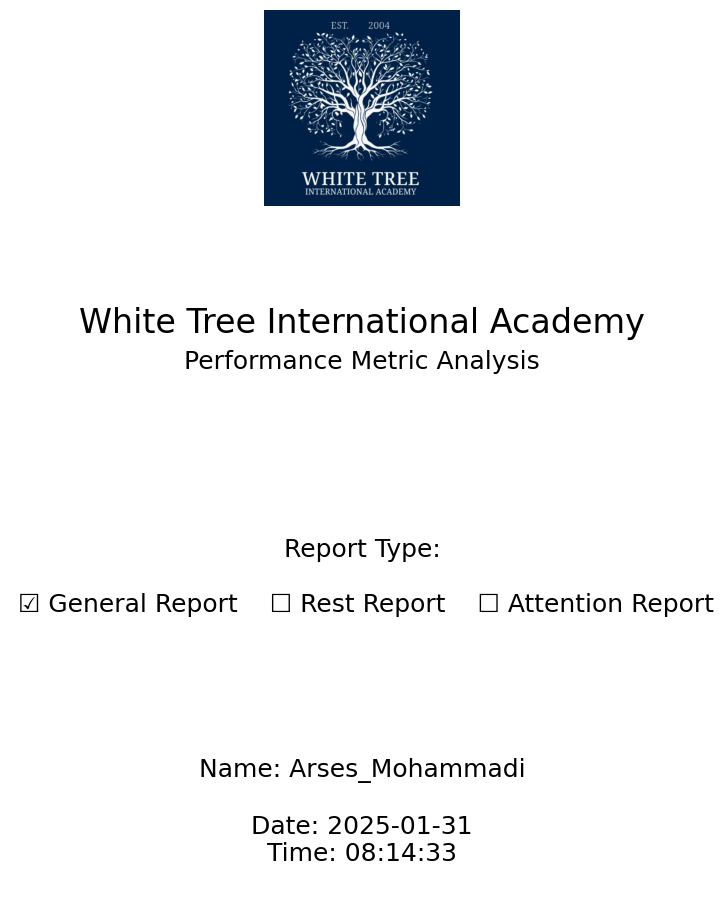

In [ ]:
# For the first report (General)
plot_maker(df, output_pdf='report_general.pdf', report_type='General')

In [ ]:
# Read the CSV file, skipping the first row
df_1 = pd.read_csv('/content/Arses_Mohammadi_INSIGHT_266576_2025.01.31T11.34.11_03.30.pm.bp.csv', skiprows=1)

# Get the column names from the second row
column_names = df.columns.tolist()
print(column_names)

['Timestamp', 'EEG.Counter', 'EEG.Interpolated', 'EEG.AF3', 'EEG.T7', 'EEG.Pz', 'EEG.T8', 'EEG.AF4', 'EEG.RawCq', 'EEG.Battery', 'EEG.BatteryPercent', 'MarkerIndex', 'MarkerType', 'MarkerValueInt', 'EEG.MarkerHardware', 'CQ.AF3', 'CQ.T7', 'CQ.Pz', 'CQ.T8', 'CQ.AF4', 'CQ.Overall', 'EQ.SampleRateQuality', 'EQ.OVERALL', 'EQ.AF3', 'EQ.T7', 'EQ.Pz', 'EQ.T8', 'EQ.AF4', 'PM.Attention.IsActive', 'PM.Attention.Scaled', 'PM.Attention.Raw', 'PM.Attention.Min', 'PM.Attention.Max', 'PM.Engagement.IsActive', 'PM.Engagement.Scaled', 'PM.Engagement.Raw', 'PM.Engagement.Min', 'PM.Engagement.Max', 'PM.Excitement.IsActive', 'PM.Excitement.Scaled', 'PM.Excitement.Raw', 'PM.Excitement.Min', 'PM.Excitement.Max', 'PM.LongTermExcitement', 'PM.Stress.IsActive', 'PM.Stress.Scaled', 'PM.Stress.Raw', 'PM.Stress.Min', 'PM.Stress.Max', 'PM.Relaxation.IsActive', 'PM.Relaxation.Scaled', 'PM.Relaxation.Raw', 'PM.Relaxation.Min', 'PM.Relaxation.Max', 'PM.Interest.IsActive', 'PM.Interest.Scaled', 'PM.Interest.Raw', 'PM.

# for dividing data into subSample

Average: 0.2270276548463357
Max: 0.287103
Min: 0.177486
Standard Deviation: 0.04042414063869303


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Average: 0.253014
Max: 0.253014
Min: 0.253014
Standard Deviation: 2.226891479496646e-16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Average: 0.2505844634569615
Max: 0.271943
Min: 0.232704
Standard Deviation: 0.013459534849122802


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Average: 0.274496
Max: 0.274496
Min: 0.274496
Standard Deviation: 7.773604975481088e-16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

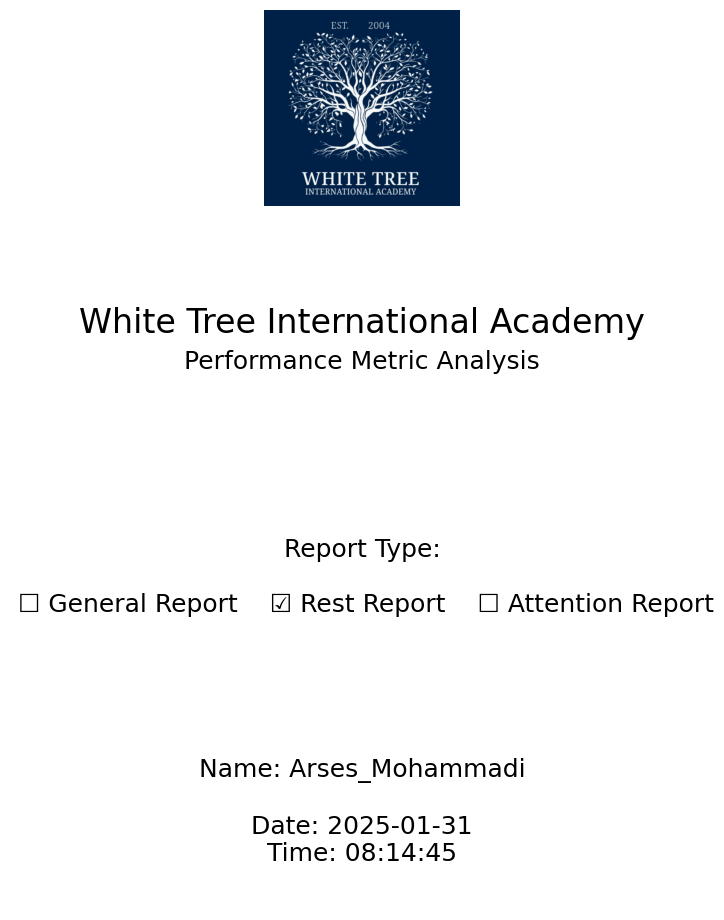

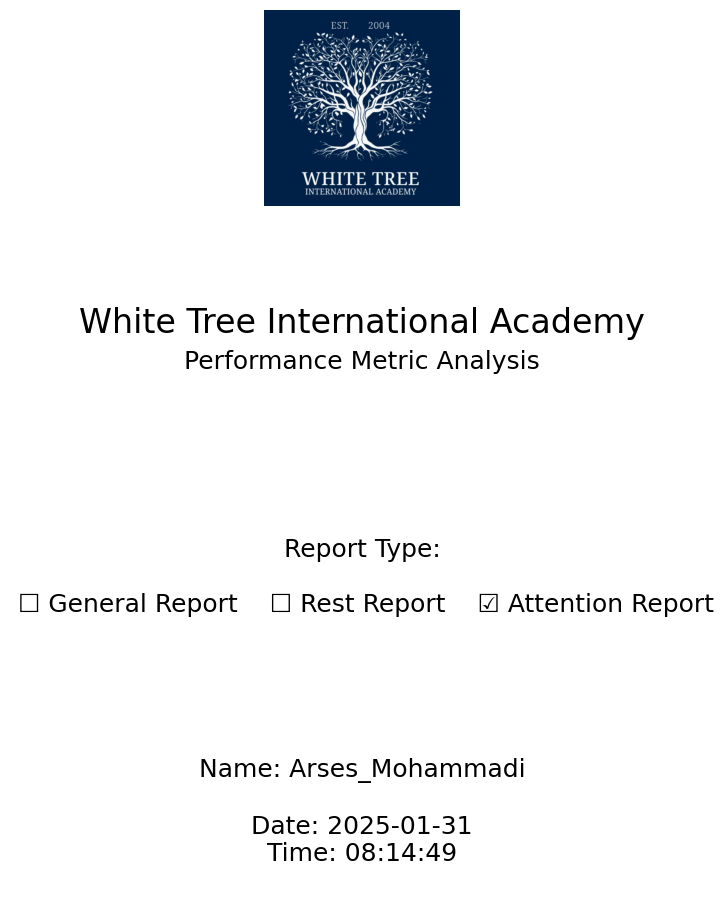

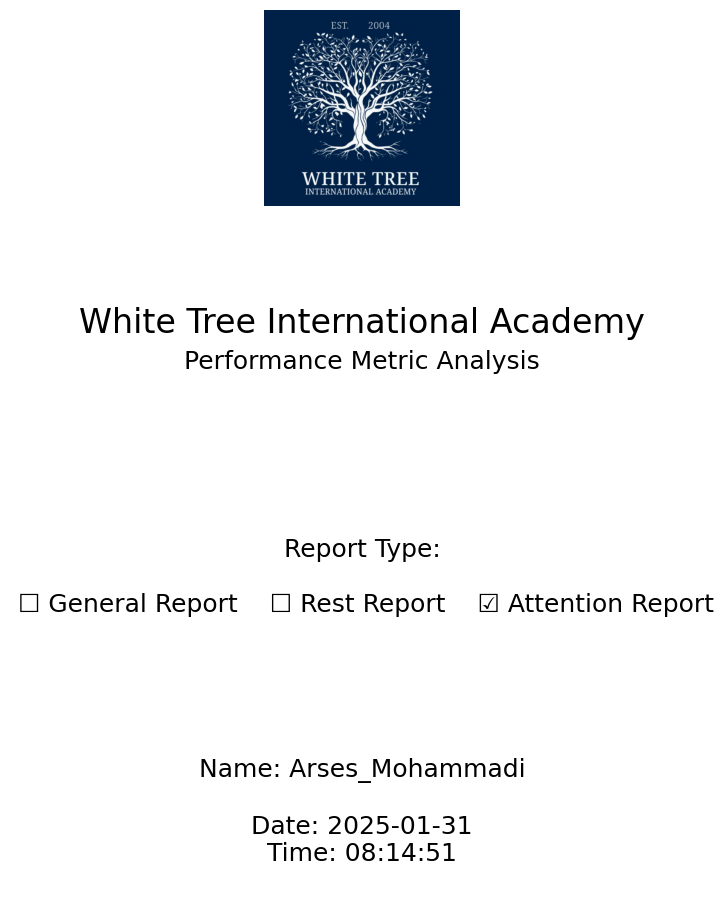

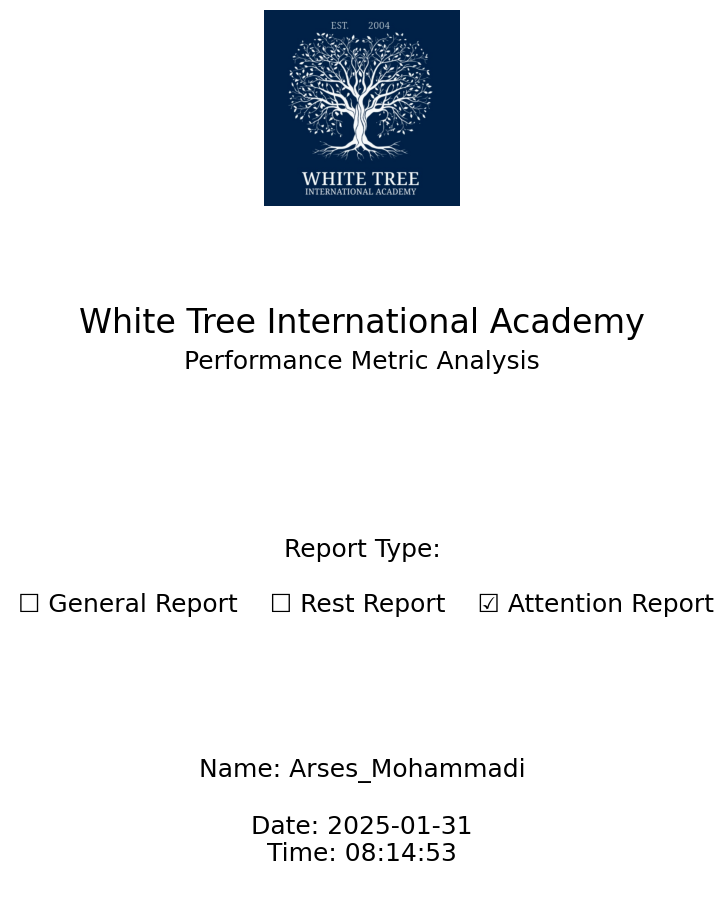

In [ ]:
# Filter out non-null MarkerValueInt entries and get their indices
marker_indices = df_1['MarkerValueInt'].dropna().index

# Create a list to store filtered DataFrames
experiment_data = []

# Loop through each pair of consecutive markers
for i in range(len(marker_indices) - 1):
    start_index = marker_indices[i]
    end_index = marker_indices[i + 1]

    # Filter data between two marker indices
    filtered_df = df_1.iloc[start_index:end_index].copy()

    # Store the filtered DataFrame in the list with a name like exp1, exp2
    experiment_data.append(filtered_df)

# Handle the last segment after the last marker
last_start_index = marker_indices[-1]
filtered_df_last = df_1.iloc[last_start_index:].copy()

# Store the last filtered DataFrame
experiment_data.append(filtered_df_last)

# Now you can pass these DataFrames to your plotting function
for i, exp_df in enumerate(experiment_data):
    if i == 0:
        report_type = 'Rest'
    else:
        report_type = 'Attention'

    plot_maker(exp_df, output_pdf=f'report_experiment_{i+1}_{report_type}.pdf', report_type=report_type)